# Using FakeBERT Architecture for Sequence Classification

[Original FakeBERT Paper](https://link.springer.com/content/pdf/10.1007/s11042-020-10183-2.pdf)

FakeBERT Architecture:

![FakeBERT](fakebert.PNG "FakeBERT Architecture")

Summary:




In [1]:
# Mount into drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# This is the location of the root directory (on github it would be cs7643-project)
# Yours might look different - Megan
root = '/content/drive/MyDrive/CS7643/Project'
#root = '/content/drive/MyDrive/sankarc/cs7643-project'

In [ ]:
# Detect PY file updates and reload
%load_ext autoreload
%autoreload 2

In [7]:
#%cd drive/MyDrive/Colab\ Notebooks/dl_project
import os
os.chdir(root)
%pwd

'/content/drive/MyDrive/CS7643/Project'

In [8]:
%ls

data/       mdl/   notebooks/  __pycache__/  source/    untitled
dataset.py  mdl1/  proposal/   README.md     Tutorials  wandb/


### Installations

In [ ]:
!pip install transformers
!pip install datasets
!pip install adjustText

In [ ]:
#!pip install -r 'requirements.txt'
!pip install -r 'notebooks/requirement.txt'

In [11]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from torch.optim import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from platform import python_version

In [12]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 31.6 MB/s 
     |████████████████████████████████| 181 kB 72.3 MB/s 
     |████████████████████████████████| 144 kB 12.9 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 


In [13]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.13
pandas==1.3.5
numpy==1.21.6
torch==1.10.0+cu111
sklearn==1.0.2
transformers==4.18.0
matplotlib==3.2.2


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Parameters (Pre-Model/Experiment)


In [17]:
# inputs
pretrained_fp = 'bert-base-uncased'
MAX_LENGTH = 100

Initialize Wandb And Sweep Configs

In [18]:
myrun=wandb.init(project="Fakebert", entity="cs7643-teamscam")
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {

        'learning_rate': {
            'values': [ 5e-5] #, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [64] #[16, 32]
        },
        'epochs':{
            'values':[3]
        }
    }
}
sweep_defaults = {
    'learning_rate': 5e-5,
    'batch_size': 68,
    'epochs':2
}

sweep_id = wandb.sweep(sweep_config)

wandb: Currently logged in as: cs7643-teamscam (use `wandb login --relogin` to force relogin)


Create sweep with ID: rqdn95hs
Sweep URL: https://wandb.ai/cs7643-teamscam/uncategorized/sweeps/rqdn95hs


In [19]:
wandb.config.batch_size = 65
wandb.config.learning_rate = 0.1
wandb.config.epochs = 2


### Get dataset, Bert tokens from preprocessed files (data/test.csv, data/train.csv)
Question (4/16/22) - After the preprocess code is completed, can we save the FINAL test, train, validation csv files in the data folder so they can be consumed by my get_data.py berty_data class? - Megan

TODO: When the preprocess code is done, the tokenizer only has to be run once and the resulting torch tensors can be saved. Add an 'if exists' check on the pickled token file to restore it from save rather than go through the 10 minute process of tokenizing each time we run this.

In [26]:
'''
Get the preprocess data from data folder and tokenize and retrieve all data (train, test, validation)
'''
from source.dataloader.get_data import bert_data

bert_data = bert_data(\
                      data_folder = 'data',\
                      train_file = 'Train_Clean.csv',\
                      test_file = 'Test_Clean.csv',\
                      val_file = 'Validate_Clean.csv',\
                      tokenizer_type = pretrained_fp,\
                      data_tokens = None)

# FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
data_tokenized = bert_data.tokenize(\
                                    col_tokenize = 'text',\
                                    add_special_tokens = True,\
                                    max_length = MAX_LENGTH,\
                                    truncation = True,\
                                    padding = 'max_length')

Using custom data configuration data-ab04d7476a5c3420
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-ab04d7476a5c3420/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-ab04d7476a5c3420/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-4a8d1e77ed08d3b6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-ab04d7476a5c3420/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-724281299f01d221.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-ab04d7476a5c3420/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-fc976bba9356a52f.arrow


In [27]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 26938
    })
    test: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8981
    })
    valid: Dataset({
        features: ['id', 'title', 'text', 'subject', 'date', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8979
    })
})

In [28]:
# Use the data_tokenized saved in data_tokenized to get the dataloaders
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader()

### get embeddings using BERT

Each file note becomes a 2D tensor:
* Each row is a token or subtoken in the sequence
* Each column is a value in the embedding (vector) for that token

In [29]:
bert_model = BertModel.from_pretrained(pretrained_fp).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Parameters (Model)

### run training data through BERT and CNN



In [30]:
import random
import time

# Specify loss function
#loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

##Example Experiment

In [32]:
from source import train
from source.models.FakeBERT import initialize_model, FakeBERTCNN
from source.plot import experiment_plot

# Parameters
EPOCHS = 10
BATCH_SIZE = 128 # 128 in paper
N_SEQUENCES = data_tokenized['train'].shape[0]
NUM_TOKENS, EMBEDDING_SIZE = (MAX_LENGTH, 768) # The num_tokens comes from max_length in tokens
NUM_FILTERS = [128, 128, 128] # [128, 128, 128] in paper
FILTER_SIZES = [3, 4, 5] #[3,4,5] in paper
NUM_CLASSES = 2
DROPOUT = 0.2
LR = 0.001
TEST_SUBSET = True # Whether or not to get a reduced size dataset (700,200,100) in train, validation, test
EMB_LAYER = 0 # For this model, we are grabbing the embeddings not the bert output

# Get Train, Val data
train_dataloader, val_dataloader, test_dataloader = bert_data.get_data_loader(batch_size = BATCH_SIZE, test_subset = TEST_SUBSET)

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

set_seed(42)
cnn_bert = initialize_model(device, max_len=MAX_LENGTH, filter_sizes=FILTER_SIZES,
                                       num_filters=NUM_FILTERS, num_classes=NUM_CLASSES,
                                       learning_rate=LR, dropout=DROPOUT)

# Optimizer
opt = Adam(cnn_bert.parameters(), lr=LR)


results = train.train(emb_model = bert_model, \
            model = cnn_bert,\
            loss_fn = loss_fn,\
            optimizer = opt,\
            train_dataloader = train_dataloader,\
            val_dataloader = val_dataloader,\
            epochs=EPOCHS,\
            bert_layer = EMB_LAYER)

Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.715039   |   50.76   |  0.712518  |   50.22   |   10.65  


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.695688   |   53.22   |  0.692650  |   50.22   |   6.57   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   3    |   0.689185   |   52.63   |  0.689864  |   50.22   |   6.57   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   4    |   0.676570   |   60.75   |  0.690975  |   50.22   |   6.54   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   5    |   0.648442   |   64.58   |  0.698084  |   50.22   |   6.58   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   6    |   0.619715   |   65.17   |  0.630776  |   58.46   |   7.85   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   7    |   0.496915   |   81.91   |  0.497842  |   76.09   |   7.95   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   8    |   0.352330   |   87.72   |  0.349823  |   85.46   |   8.03   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   9    |   0.213628   |   92.41   |  0.467165  |   80.12   |   6.66   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  10    |   0.162553   |   94.11   |  0.518179  |   81.60   |   6.73   


Training complete! Best accuracy: 85.46%.


epochs: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
train_loss: [0.7150389  0.69568819 0.68918514 0.6765699  0.64844196 0.61971498
 0.49691527 0.35232964 0.21362837 0.16255276] 
val_loss: [0.71251833 0.69265047 0.68986386 0.69097477 0.69808382 0.63077551
 0.49784166 0.34982277 0.4671645  0.51817904]


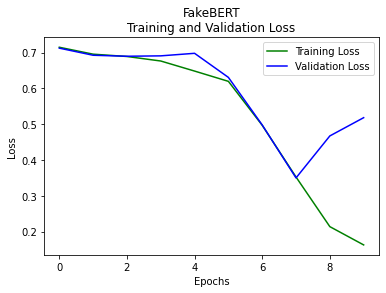

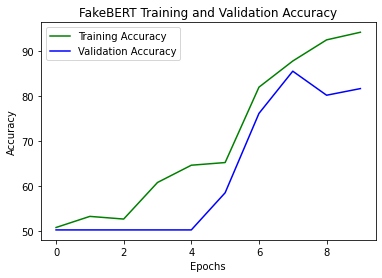

In [33]:

plot_runner = experiment_plot(results = results,\
                              save_name = "BERT" + '-' \
                                        + 'SEQ' + str(MAX_LENGTH)\
                                        + '-LR' + str(LR)\
                                        + '-DO' + str(DROPOUT)\
                                        + '-BS' + str(BATCH_SIZE),
                              save_path = "source/experiments/figures/",\
                              append_time = True
                              )
plot_runner.plot(title_prepend = "FakeBERT",\
                 include_points = False)

### evaluate model performance on test data

In [34]:
from source import train, evaluate
test_loss, test_accuracy = evaluate.evaluate(bert_model, cnn_bert, loss_fn, test_dataloader)

print('Final Loss and Accuracy on Test: (%s,%s)' % (test_loss, test_accuracy))

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.41430404782295227,85.0)


In [35]:
myrun.finish()

avg_train_loss,████▇▇▅▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▃▃▃▆▇██
val_accuracy,▁▁▁▁▁▃▆█▇▇
val_loss,█████▆▄▁▃▄
avg_train_loss,0.16255
epoch,9
train_acc,94.1059
val_accuracy,81.59722
val_loss,0.51818


### References

https://romanorac.github.io/machine/learning/2019/12/02/identifying-hate-speech-with-bert-and-cnn.html